In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
import scipy.fftpack
import scipy as sp
%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv('clean.csv',parse_dates=['date'])
df.head()

,Unnamed: 0,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name
0,0,ahmednagar,bajri,2015,April,79.0,1406.0,1538.0,1463.0,2015-04-01,Ahmadnagar
1,1,ahmednagar,bajri,2016,April,106.0,1788.0,1925.0,1875.0,2016-04-01,Ahmadnagar
2,2,ahmednagar,wheat(husked),2015,April,1253.0,1572.0,1890.0,1731.0,2015-04-01,Ahmadnagar
3,3,ahmednagar,wheat(husked),2016,April,387.0,1750.0,2220.0,1999.0,2016-04-01,Ahmadnagar
4,4,ahmednagar,sorgum(jawar),2015,April,3825.0,1600.0,2200.0,1900.0,2015-04-01,Ahmadnagar


In [3]:
df.drop(['Unnamed: 0','district_name'],axis=1,inplace=True)
df.head()


,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date
0,ahmednagar,bajri,2015,April,79.0,1406.0,1538.0,1463.0,2015-04-01
1,ahmednagar,bajri,2016,April,106.0,1788.0,1925.0,1875.0,2016-04-01
2,ahmednagar,wheat(husked),2015,April,1253.0,1572.0,1890.0,1731.0,2015-04-01
3,ahmednagar,wheat(husked),2016,April,387.0,1750.0,2220.0,1999.0,2016-04-01
4,ahmednagar,sorgum(jawar),2015,April,3825.0,1600.0,2200.0,1900.0,2015-04-01


### First, we will get see how the mean of modal price changes with time by finding mean of all the commodities (individually, across all APMC) for each month. 
### <font color=red> Note: Taking a leap of faith that all the APMCs suffer the same price changes due to various factors e.g. 'drought'</font>

In [4]:
trendline = pd.pivot_table(df,index='Commodity',columns=['date'],aggfunc='mean')

In [5]:
trendline['modal_price'].head()

date,2014-09-01 00:00:00,2014-10-01 00:00:00,2014-11-01 00:00:00,2014-12-01 00:00:00,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,...,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,2016-10-01 00:00:00,2016-11-01 00:00:00
Commodity,,,,,,,,,,,,,,,,,,,,,
amba koy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1500.000000,3750.000000,4750.000000,NaN,NaN,NaN,NaN
ambat chuka,NaN,136.000000,167.000000,270.000000,NaN,NaN,NaN,196.0,NaN,1350.0,...,NaN,NaN,193.000000,NaN,500.000000,325.500000,919.250000,665.500000,748.000000,1251.0
amla,1400.000000,1777.000000,1580.000000,1634.000000,1637.5,1800.0,1800.0,NaN,NaN,NaN,...,1275.000000,NaN,NaN,NaN,NaN,NaN,NaN,2500.000000,1700.000000,1500.0
apple,6342.666667,5922.571429,6042.833333,5164.833333,5544.0,5137.0,6233.6,8497.0,10089.0,10161.0,...,6312.333333,8293.6,9961.444444,8287.169723,9883.186695,8796.169723,7157.528227,7171.989766,6615.083333,6905.6
arvi,2520.500000,2397.500000,2521.000000,2266.500000,2800.0,2622.5,2313.5,2405.5,2149.0,2207.5,...,1885.000000,2135.0,2371.500000,2484.333333,2434.500000,2425.000000,2267.000000,2043.000000,2006.500000,2010.5


###  Example to use the trendline pivot table to get monthly trendline for any commodity
trendline['feature_name'].loc['commodity_name'].plot()

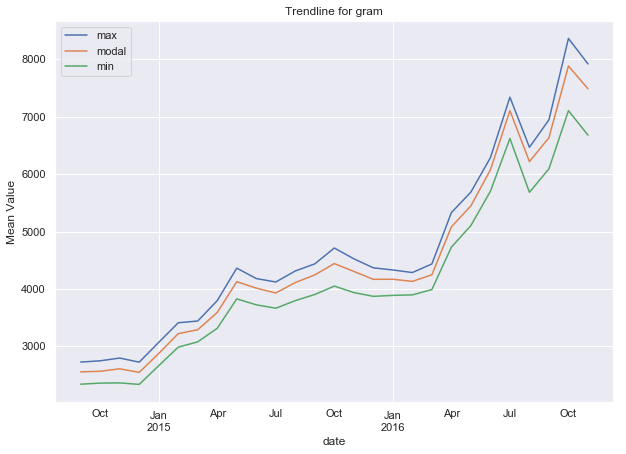

In [6]:
plt.figure(figsize=(10,7))
trendline['max_price'].loc['gram'].plot()
trendline['modal_price'].loc['gram'].plot()
trendline['min_price'].loc['gram'].plot()
plt.title('Trendline for gram')
plt.ylabel('Mean Value')
plt.legend(['max','modal','min'])

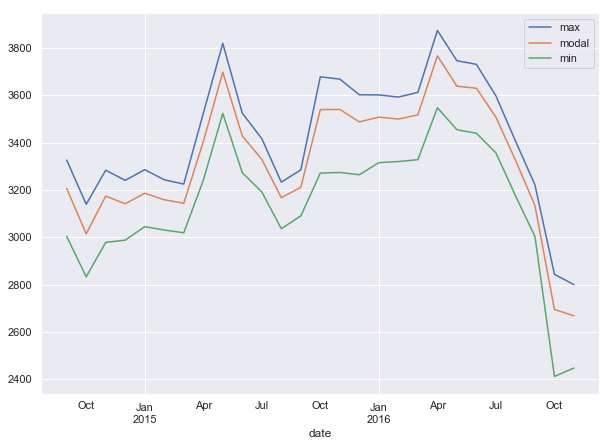

In [7]:
plt.figure(figsize=(10,7))
trendline['max_price'].loc['soybean'].plot()
trendline['modal_price'].loc['soybean'].plot()
trendline['min_price'].loc['soybean'].plot()
plt.legend(['max','modal','min'])

### The above two plots show that a generalization cannot be made about the trend for different commodity
### Mean values generated in the previous stage will be used to remove trend from the data.
### Note to self: <font color=red> Note: Subtracting the prices averaged for each month across all the APMC and subtracting the same from all the data assumes an additive behavior. </font>
### $f(t) = trend(t)+seasonal(t)+ other \,components (t)$

In [8]:
monthly_data = df.groupby(['date', 'Commodity'])['modal_price'].mean().reset_index(name='Monthly Average')
std_data = df.groupby(['date', 'Commodity'])['modal_price'].std().reset_index(name='Monthly Std')

In [9]:
new_df = df.merge(monthly_data,on=['date','Commodity'])
new_df = new_df.merge(std_data,on=['date','Commodity'])

In [10]:
new_df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,Monthly Average,Monthly Std
0,ahmednagar,bajri,2015,April,79.0,1406.0,1538.0,1463.0,2015-04-01,1370.865672,209.2758
1,akole,bajri,2015,April,52.0,1357.0,1800.0,1525.0,2015-04-01,1370.865672,209.2758
2,jamkhed,bajri,2015,April,164.0,1304.0,1446.0,1375.0,2015-04-01,1370.865672,209.2758
3,kopargaon,bajri,2015,April,354.0,1164.0,1469.0,1401.0,2015-04-01,1370.865672,209.2758
4,newasa,bajri,2015,April,32.0,1282.0,1293.0,1286.0,2015-04-01,1370.865672,209.2758


In [11]:
gram = new_df[new_df['Commodity']=='gram']
gram.sort_values(by='date',inplace=True)
type(gram)

C:\Users\vipul\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


pandas.core.frame.DataFrame

Text(0.5, 0, 'Date')

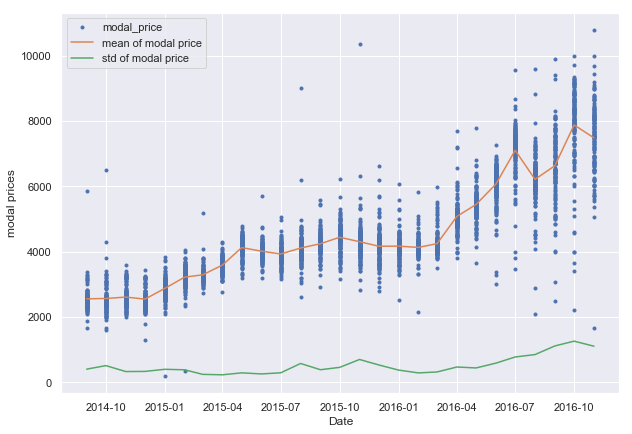

In [12]:
plt.figure(figsize=(10,7))
plt.plot(gram['date'],gram['modal_price'],'.')
plt.plot(gram['date'],gram['Monthly Average'],'-')
plt.plot(gram['date'],gram['Monthly Std'])
plt.legend(['modal_price','mean of modal price','std of modal price'])
plt.ylabel('modal prices')
plt.xlabel('Date')

In [13]:
new_df['fluctuation'] = new_df['modal_price']-new_df['Monthly Average']

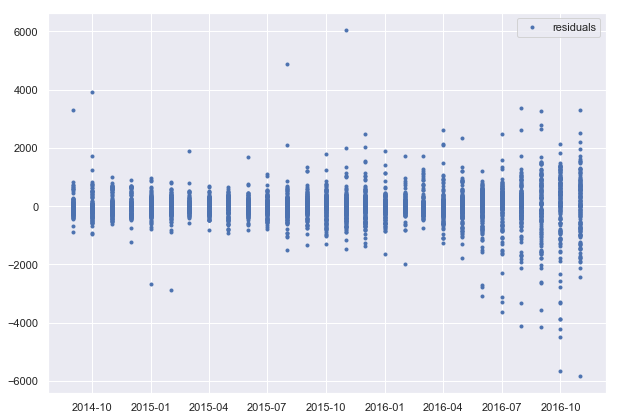

In [14]:
plt.figure(figsize=(10,7))
plt.plot(new_df[new_df['Commodity']=='gram']['date'],new_df[new_df['Commodity']=='gram']['fluctuation'],'.')
plt.legend(['residuals'])

### The above process helped to remove the trend and have a zero mean. 
### Re-assessing the mean and standard deviation after trend removal

In [15]:
fluctuation_mean = new_df.groupby(['date', 'Commodity'])['fluctuation'].mean().reset_index(name='Fluctuation_Mean')
fluctuation_std = new_df.groupby(['date', 'Commodity'])['fluctuation'].std().reset_index(name='Fluctuation_Std')

In [16]:
new_df = new_df.merge(fluctuation_mean,on=['date','Commodity'])
new_df = new_df.merge(fluctuation_std,on=['date','Commodity'])

In [17]:
new_df.sort_values(by='date')
new_df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,Monthly Average,Monthly Std,fluctuation,Fluctuation_Mean,Fluctuation_Std
0,ahmednagar,bajri,2015,April,79.0,1406.0,1538.0,1463.0,2015-04-01,1370.865672,209.2758,92.134328,-5.090455e-14,209.2758
1,akole,bajri,2015,April,52.0,1357.0,1800.0,1525.0,2015-04-01,1370.865672,209.2758,154.134328,-5.090455e-14,209.2758
2,jamkhed,bajri,2015,April,164.0,1304.0,1446.0,1375.0,2015-04-01,1370.865672,209.2758,4.134328,-5.090455e-14,209.2758
3,kopargaon,bajri,2015,April,354.0,1164.0,1469.0,1401.0,2015-04-01,1370.865672,209.2758,30.134328,-5.090455e-14,209.2758
4,newasa,bajri,2015,April,32.0,1282.0,1293.0,1286.0,2015-04-01,1370.865672,209.2758,-84.865672,-5.090455e-14,209.2758


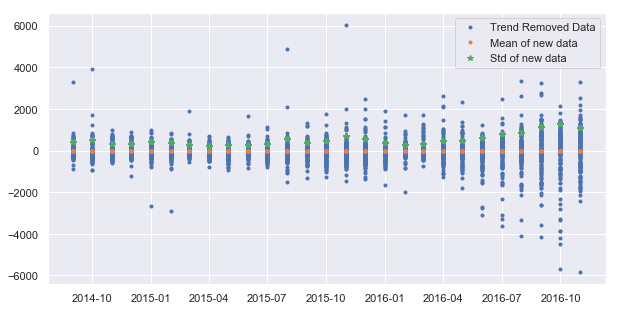

In [18]:
plt.figure(figsize=(10,5))
gram = new_df[new_df['Commodity']=='gram']
plt.plot(gram['date'],gram['fluctuation'],'.')
plt.plot(gram['date'],gram['Fluctuation_Mean'],'.',linewidth=10)
plt.plot(gram['date'],gram['Fluctuation_Std'],'*',linewidth=20)
plt.legend(['Trend Removed Data','Mean of new data','Std of new data'])

### The above plot shows that the data is scattered around zero. thus, removal of trend seems to be fine.
### Did trend removal have any effect on standard deviation? My guess says no. -> if true; indicates multiplicative might be a better option? 

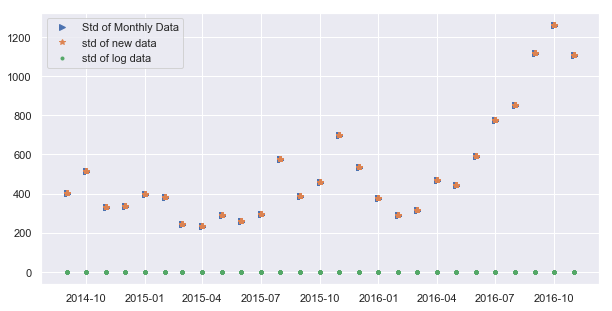

In [19]:
plt.figure(figsize=(10,5))
gram = new_df[new_df['Commodity']=='gram']
plt.plot(gram['date'],gram['Monthly Std'],'>')
plt.plot(gram['date'],gram['Fluctuation_Std'],'*',linewidth=20)
plt.plot(gram['date'],gram['Fluctuation_Mean'],'.',linewidth=10)
plt.legend(['Std of Monthly Data','std of new data','std of log data'])

### A varying standard deviation suggests presence of seasonality in the data. We can analyze the periodogram to obtain the frequency components present in the data. Periodogram is also defined as the Fourier Transform of the autocorrelation function of the time-varying data. 
### $F(\omega)=\int_{-\infty}^{\infty}f(t)f^*(t)\exp(i\omega t)dt$
### Since the data available is real; therefore $f^*(t) = f(t)$

In [20]:
def periodogram(dataset,series_name,commodity_name,x_min=0,x_max=2.0):
    series = np.array(dataset[dataset['Commodity']==commodity_name][series_name])**2
    price_fft = sp.fftpack.fft(series)
    price_psd = np.abs(price_fft) ** 2
    fftfreq = sp.fftpack.fftfreq(len(price_psd),1/365)
    time_ = 1/fftfreq
    i = fftfreq > 0
    plt.figure(figsize=(10,7))
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(time_[i], price_psd[i])
    plt.xlim(x_min,x_max)
    ax.set_xlabel('Time Period (year)')
    ax.set_ylabel('Power Spectral Density')
    plt.legend([commodity_name])

### Below are some spectrum to judge the performance of the method used above to remove non-stationarity. 
### This is later reflected upon in the adfuller stats

C:\Users\vipul\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


<Figure size 720x504 with 0 Axes>

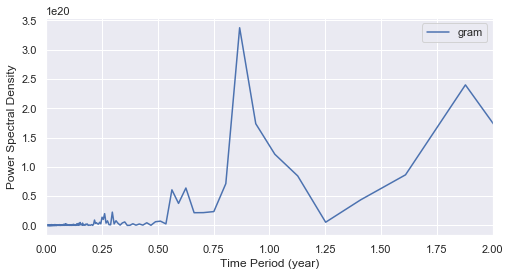

<Figure size 720x504 with 0 Axes>

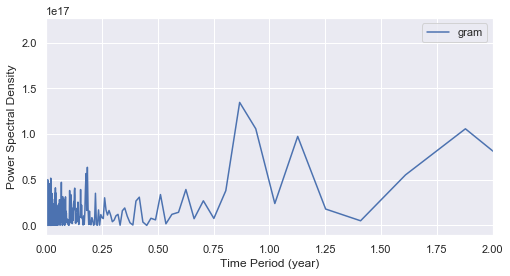

<Figure size 720x504 with 0 Axes>

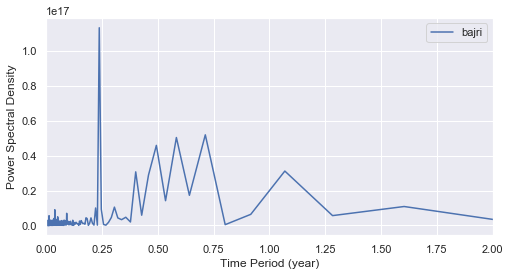

<Figure size 720x504 with 0 Axes>

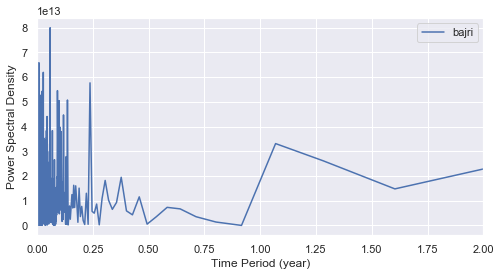

<Figure size 720x504 with 0 Axes>

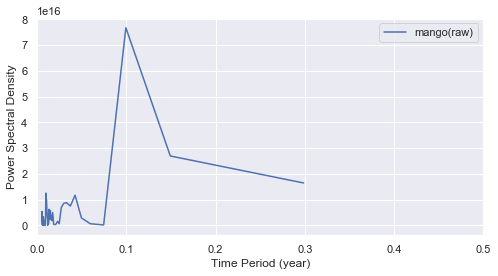

<Figure size 720x504 with 0 Axes>

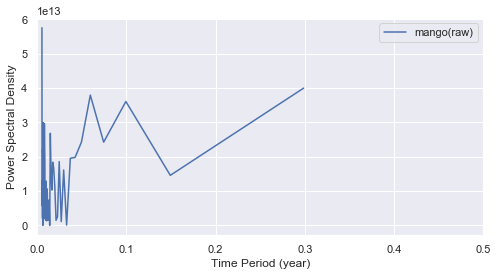

In [21]:
periodogram(new_df,'modal_price','gram')
periodogram(new_df,'fluctuation','gram')
periodogram(new_df,'modal_price','bajri')
periodogram(new_df,'fluctuation','bajri')
periodogram(new_df,'modal_price','mango(raw)',0,.5)
periodogram(new_df,'fluctuation','mango(raw)',0,0.5)

### As per online research and suggestion by Prof. Ariel Linden (researchgate), in order to build ARIMA models, we need atleast 100 data points.  Also, adfuller test suggests that maxlag<number of observer points. So, removing these data points on this condition seems logical.

In [22]:
def maxlag(x): return int(12.0*pow((len(x)/100.0),0.25))

In [23]:
relevant_data = new_df[['Commodity','modal_price','fluctuation']]
commodity     = np.array(pd.pivot_table(new_df,index='Commodity').index)

In [24]:
print ('old shape: ',new_df.shape)
for i in range(0,len(commodity)):
    series = new_df[new_df['Commodity']==commodity[i]]['modal_price']
    if (maxlag(series)<12):
        indexes = new_df[new_df['Commodity']==commodity[i]].index
        new_df.drop(indexes,inplace=True,axis=0)

commodity = np.array(pd.pivot_table(new_df,index='Commodity').index)
print ('new shape: ',new_df.shape)

old shape:  (62220, 14)
new shape:  (59617, 14)


### Define the hypothesis to test the generated data for seasonality and trend
### Null Hypothesis: The data 'modal_prices' contains seasonality and trend
### Alternate Hypothesis: The data 'modal prices' doesnt contain any seasonality or trend

In [25]:
from statsmodels.tsa.stattools import adfuller
def adf(x):
    result = adfuller(x)
    adf_stat = result[0]
    p_value  = result[1]
    cv_1     = result[4].get('1%')
    cv_5     = result[4].get('5%')
    cv_10    = result[4].get('10%')
    return [adf_stat,p_value,cv_1,cv_5,cv_10]

In [26]:
### defining a function to perform adfuller test on a series (defined by series_name) contained within (dataframe)
### for a list of commodity of interest.
def test_adf(dataframe,series_name,commodity):
    name=[]
    stationarity=[]
    adf_stats = []
    p_value = []
    cv_1 = []
    cv_5 = []
    cv_10 = []
    for i in range(0,len(commodity)):
        series = np.array(dataframe[dataframe['Commodity']==str(commodity[i])][series_name])
        name.append(commodity[i])
        result = adf(series)
        adf_stats.append(result[0])
        p_value.append(result[1])
        cv_1.append(result[2])
        cv_5.append(result[3])
        cv_10.append(result[4])
        test_stas = pd.DataFrame({'name':name,'adf':adf_stats,'p_value':p_value,'critical value 1%':cv_1,'critical value 5%':cv_5,'critical value 10%':cv_10}) 
        test_stas.set_index('name',inplace=True)
    return test_stas

### Earlier, monthly average of 'modal_prices' was taken and then subtracted from the main dataset. 
### Below is the adfuller test to check the number of data points with a significance level of greater than 1% 

In [27]:
on_modal_price = test_adf(new_df,'modal_price',commodity)
on_monthly_averaged = test_adf(new_df,'fluctuation',commodity)

In [28]:
ind = on_modal_price['adf']>on_modal_price['critical value 1%']
on_modal_price[ind].head()

,adf,p_value,critical value 1%,critical value 5%,critical value 10%
name,,,,,
bitter gourd,-3.352542,0.012687,-3.438449,-2.865115,-2.568674
cotton,-3.074083,0.028532,-3.436611,-2.864304,-2.568242
cucumber,-3.100062,0.026549,-3.438399,-2.865093,-2.568662
ghosali(bhaji),-3.031216,0.032080,-3.465812,-2.877123,-2.575077
green chilli,-3.138132,0.023857,-3.438206,-2.865008,-2.568616


In [29]:
on_monthly_averaged[ind].head()

,adf,p_value,critical value 1%,critical value 5%,critical value 10%
name,,,,,
bitter gourd,-10.281164,3.776413e-18,-3.438530,-2.865151,-2.568693
cotton,-11.000672,6.694936e-20,-3.436599,-2.864299,-2.568239
cucumber,-11.209476,2.143347e-20,-3.438360,-2.865075,-2.568653
ghosali(bhaji),-8.048999,1.762722e-12,-3.466005,-2.877208,-2.575122
green chilli,-10.403479,1.882931e-18,-3.438321,-2.865058,-2.568643


In [30]:
on_monthly_averaged[on_monthly_averaged['adf']>on_monthly_averaged['critical value 1%']]

,adf,p_value,critical value 1%,critical value 5%,critical value 10%
name,,,,,


### The above test shows that there is less than 1% probability that removing the monthly average from the modal prices has not removed the trend and the seasonality from all the commodity data.

In [33]:
new_df.to_csv('after_removing_additive.csv')

### Above, a new file has been created which contains a new column ''fluctuation". This column contains detrended and deseasonalised data (residuals) and may be suitable for modelling purposes.
